In [ ]:
!pip install pyldavis

In [31]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis.lda_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Load the dataset
data = pd.read_csv('Tweets.csv')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define punctuation
punctuations = set(string.punctuation)

# Define function to clean text
def clean_text(text):
    # Tokenize text into words
    words = word_tokenize(text.lower())
    
    # Remove stopwords and punctuations
    words = [word for word in words if word not in stop_words and word not in punctuations]
    
    # Join words back into a sentence
    clean_text = ' '.join(words)
    
    return clean_text

# Apply function to clean the text data
data['clean_text'] = data['text'].apply(clean_text)

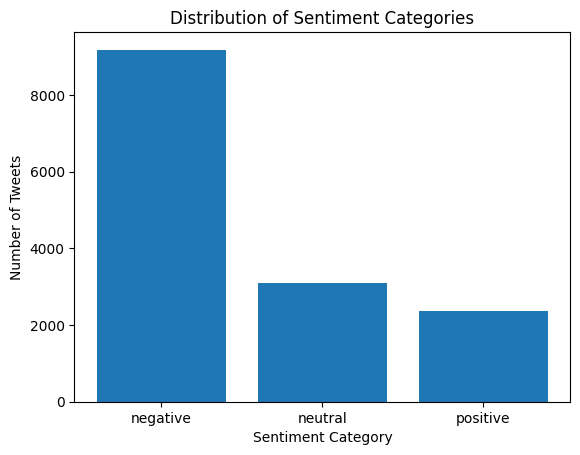

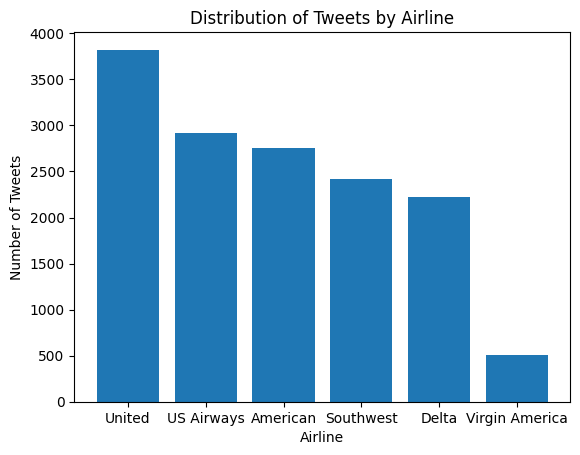

In [33]:
# count the number of tweets in each sentiment category
sentiment_counts = data['airline_sentiment'].value_counts()

# plot the distribution of sentiment categories
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Tweets')
plt.show()

# count the number of tweets for each airline
airline_counts = data['airline'].value_counts()

# plot the distribution of tweets for each airline
plt.bar(airline_counts.index, airline_counts.values)
plt.title('Distribution of Tweets by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.show()

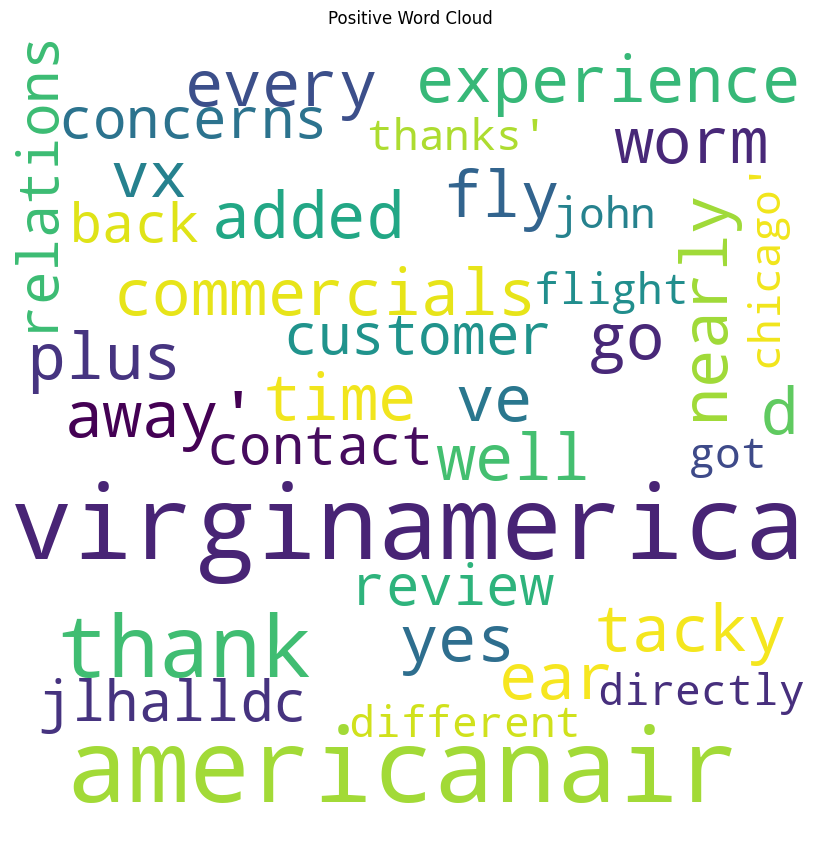

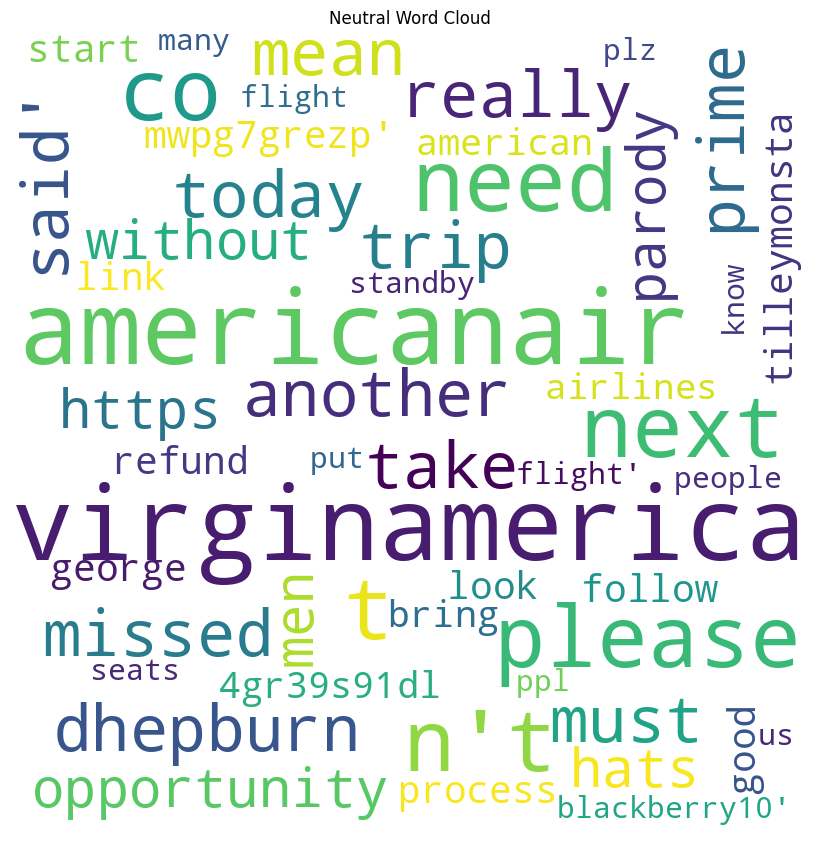

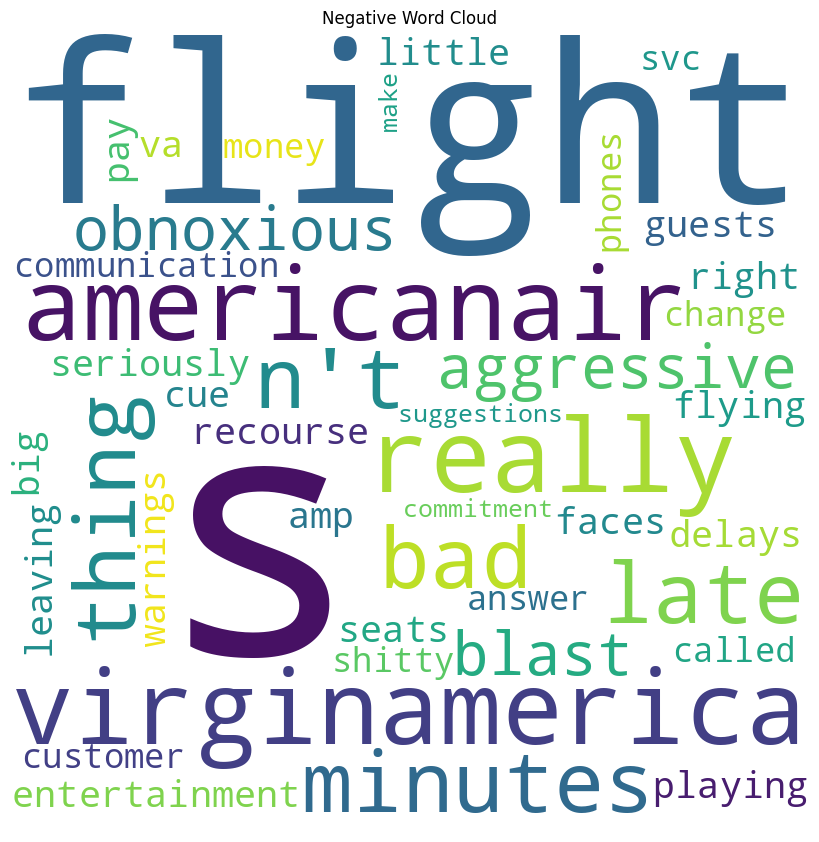

In [35]:
from wordcloud import WordCloud

# plot the word cloud for each sentiment label
sentiments = ['positive', 'neutral', 'negative']
for sentiment in sentiments:
    text = data[data['airline_sentiment'] == sentiment]['clean_text'].values
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(str(text))
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f'{sentiment.capitalize()} Word Cloud')
    plt.show()

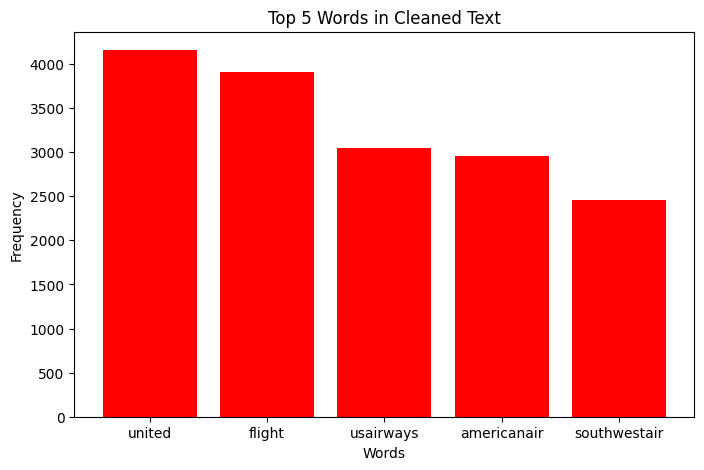

In [46]:
from collections import Counter

# Combine all text in the clean_text column into a single string
all_text = ' '.join(data['clean_text'].tolist())

# Split the text into individual words and count their frequency
word_counts = Counter(all_text.split())

top_words = word_counts.most_common(5)  # Select top 5 words

# Create lists of words and their corresponding frequencies
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]

# Create a bar chart of the top 7 words
plt.figure(figsize=(8, 5))
plt.bar(words, frequencies, color='r')
plt.title("Top 5 Words in Cleaned Text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define vectorizer and LDA model
vectorizer = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1, 2), stop_words='english')
lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', random_state=42)

# Vectorize the cleaned text data
X = vectorizer.fit_transform(data['clean_text'])

# Fit the LDA model to the vectorized data
lda_model.fit(X)

In [11]:
# Print the topics and their corresponding top words
for index, topic in enumerate(lda_model.components_):
    print(f'Topic {index+1}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

# Transform the vectorized data into topic probabilities for each document
doc_topic_probs = lda_model.transform(X)

# Add the topic probabilities to the dataset
for i in range(1, 6):
    data[f'topic_{i}_prob'] = doc_topic_probs[:, i-1]

# Evaluate the LDA model using the perplexity metric
perplexity = lda_model.perplexity(X)
print(f'Perplexity: {perplexity}')

Topic 1:
['travel', 'aa', 'minutes', 'ca', 'fly', 'time', 'http', 'hold', 'jetblue', 'southwestair']


Topic 2:
['sitting', 'dfw', 'days', 'plane', 'going', 'weather', 'waiting', 'guys', 'gate', 'thank']


Topic 3:
['amp', 'people', 'wait', 'time', 'bag', 'late', 'delayed', 'hours', 'united', 'flight']


Topic 4:
['amp', 'dm', 'told', 'good', 'plane', 'http', 'southwestair', 'thanks', 'jetblue', 'united']


Topic 5:
['cancelled flightled', 'flightled', 'help', 'customer service', 'customer', 'service', 'cancelled', 'flight', 'usairways', 'americanair']


Perplexity: 509.81095258035293


In [32]:
vis = pyLDAvis.lda_model.prepare(lda_model, X, vectorizer, sort_topics=False)
pyLDAvis.display(vis)

In [22]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_coherence_score(model, df_column):
    topics = model.components_
    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df_column]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [25]:
coherence = get_coherence_score(lda_model, data['clean_text'])
print('Coherence Score: ', coherence)

Coherence Score:  0.6926094157687682
